This file will be used for some explinitory data analysis of the kings county data. This data set was provided to students of the flat iron school in order to implement a linear regression model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from itertools  import tee

In [2]:
df = pd.read_csv("..\data\kc_house_data.csv")
df.head() # inspecting our dataframe and seeing our columns and some basic values

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Notice that 'waterfront' and 'yr_renovated' appear to be the only columns with null values, however we shall further inspect these columns and see if this is in fact the case.


In [3]:
df.info() # notice that 'waterfront' and 'yr_renovated' and "view" appear to be the only columns with null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df[["date", "yr_built", "yr_renovated", "waterfront", "view", "condition", "grade", "sqft_basement"]] # a subset of our dataframe with only
# the columns that need cleaning

,date,yr_built,yr_renovated,waterfront,view,condition,grade,sqft_basement
0,10/13/2014,1955,0.0,NaN,NONE,Average,7 Average,0.0
1,12/9/2014,1951,1991.0,NO,NONE,Average,7 Average,400.0
2,2/25/2015,1933,NaN,NO,NONE,Average,6 Low Average,0.0
3,12/9/2014,1965,0.0,NO,NONE,Very Good,7 Average,910.0
4,2/18/2015,1987,0.0,NO,NONE,Average,8 Good,0.0
...,...,...,...,...,...,...,...,...
21592,5/21/2014,2009,0.0,NO,NONE,Average,8 Good,0.0
21593,2/23/2015,2014,0.0,NO,NONE,Average,8 Good,0.0
21594,6/23/2014,2009,0.0,NO,NONE,Average,7 Average,0.0
21595,1/16/2015,2004,0.0,NaN,NONE,Average,8 Good,0.0


In [5]:
df["date"] = pd.to_datetime(df["date"]) #changing date column from string to datetime format

df["date"].min(), df["date"].max() #notice our dataset only includes data from one year

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

In [6]:
df.yr_renovated.fillna(0.0, inplace= True) # replacing NaN values with 0.0 in yr_renovated column

df.yr_renovated.isna().sum() # checking to see if there are any NaN values

0

In [7]:
df["sqft_basement"].replace(to_replace= "?", value = 0.0, inplace= True ) # replacing ? with 0.0 in our sqft_basement column

df["sqft_basement"] = df["sqft_basement"].astype("float") #converting sqft_basement to type float

In [8]:
df.waterfront.fillna("NO", inplace= True) #filling in NaN values with NO for waterfront

df.waterfront = df.waterfront.eq('YES').mul(1) # now converting YES and NO to 1 and 0 respectively, this will help with our model fitting later

df.sample()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11393,5700004485,2014-05-20,978000.0,4,2.75,2620,13777,1.5,0,AVERAGE,...,9 Better,1720,900.0,1926,0.0,98144,47.58,-122.285,3530,9287


In [9]:
df.view.unique() # inspecting view column to see if there are any NaN values

df.view.fillna("NONE", inplace = True) #filling in NaN values with string NONE

Now it is time to move away from filling in our null values and correcting our data types and to begin dealing with our ordinal columns.

In [10]:
df["renovated"] = df["yr_renovated"].apply(lambda x: 0 if x==0.0 else 1) # adding a new column where 1 means home was renovated and 0 is never renovated

In [11]:
df.yr_renovated.fillna(df['yr_built'], inplace= True) # replacing NaN values with corresponding yr_built value
# in yr_renovated column
df.yr_renovated.isna().sum() # checking to see if there are any NaN values

0

In [12]:
df["grade"] = df.grade.apply(lambda x: (int(x[0:2]))) # adding a grade numeric column which is derived from the grade column.
# Only using the integer grading (3-13)

In [13]:
ord_cat_selector = ['view', 'condition', 'grade'] # these three columns all have ordinal data and must be dealt with accordingly

cat_subset = df[ord_cat_selector] # a subset of our dataframe with only ordinal data

cat_subset

,view,condition,grade
0,NONE,Average,7
1,NONE,Average,7
2,NONE,Average,6
3,NONE,Very Good,7
4,NONE,Average,8
...,...,...,...
21592,NONE,Average,8
21593,NONE,Average,8
21594,NONE,Average,7
21595,NONE,Average,8


In [14]:
cat_subset['view'].unique() #inspecting the columns and arranging the values accordingly
cat_subset['condition'].unique()
cat_subset['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

In [15]:
view_list = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'] # order for each column (least to greatest)
condition_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
grade_list = [3,4,5,6,7,8,9,10,11,12,13]

In [16]:
o_enc = OrdinalEncoder(categories = [view_list, condition_list, grade_list])
o_enc.fit(cat_subset)

OrdinalEncoder(categories=[['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'],
                           ['Poor', 'Fair', 'Average', 'Good', 'Very Good'],
                           [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]])

In [17]:
X_subset = pd.DataFrame(o_enc.transform(cat_subset), columns = cat_subset.columns) # create a new ordinal encoded dataframe

#Merge with our original dataframe
transformed_df =df.join(X_subset, rsuffix= "_ord")

# dropping columns redundant columns that were used to derive ordinal columns
transformed_df.drop(columns = ["view", "condition", "grade"], inplace= True)

In [18]:
transformed_df["age"] = 2015 - transformed_df["yr_built"] # adding an age column that gives us the total age of the home

Noticed an outlier in our dataframe and decided to manually edit it, using online airbnb data.

In [19]:
transformed_df.loc[transformed_df.bedrooms == transformed_df.bedrooms.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,1040,...,98103,47.6878,-122.331,1330,4700,0,0.0,4.0,4.0,68


In [20]:
transformed_df['bedrooms'][15856] = 3 # setting the correct number of bedrooms for this entry, found via zillow

C:\Users\pedro\AppData\Local\Temp\ipykernel_19292\3309542827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['bedrooms'][15856] = 3 # setting the correct number of bedrooms for this entry, found via zillow


In [21]:
transformed_df.loc[transformed_df.bedrooms == transformed_df.bedrooms.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age
8748,1773100755,2014-08-21,520000.0,11,3.0,3000,4960,2.0,0,2400,...,98106,47.556,-122.363,1420,4960,1,0.0,2.0,4.0,97


In [22]:
lat_long = transformed_df[['lat', 'long']]

Now it is time to add a special feature to our dataframe, distance to seattle downtown from your home.

In [23]:
#pairwise function implemented to iterate through two consecutive rows (pairs) in a data frame
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


In [24]:
#empty list - will be used to store calculated distances
list = [0]

# Loop through each row in the data frame using pairwise
for (i1, row1), (i2, row2) in pairwise(lat_long.iterrows()):
    #Assign latitude and longitude as origin/departure points
    LatOrigin = row1['lat']
    LongOrigin = row1['long']
    point = (LatOrigin, LongOrigin)
    list.append(point)
#Add column 'Distance' to data frame and assign to list values
transformed_df['point'] = list

In [25]:
transformed_df['point'][0] = (47.5112, -122.257)

C:\Users\pedro\AppData\Local\Temp\ipykernel_19292\3376504046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df['point'][0] = (47.5112, -122.257)


In [26]:
transformed_df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,lat,long,sqft_living15,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age,point
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,1180,...,47.5112,-122.257,1340,5650,0,0.0,2.0,4.0,60,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,2170,...,47.7210,-122.319,1690,7639,1,0.0,2.0,4.0,64,"(47.5112, -122.257)"
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,770,...,47.7379,-122.233,2720,8062,0,0.0,2.0,3.0,82,"(47.721, -122.319)"


In [27]:
downtown_seattle = (47.6050, -122.3344)

import geopy.distance

transformed_df['distance_to_downtown_seattle_miles'] = transformed_df['point'].apply(lambda point: geopy.distance.geodesic(downtown_seattle, point).miles)

In [28]:
transformed_df['distance_to_downtown_seattle_miles'].describe()

count    21597.000000
mean        11.512733
std          6.609141
min          0.719565
25%          6.114526
50%         10.350290
75%         15.774479
max         48.161387
Name: distance_to_downtown_seattle_miles, dtype: float64

Here are two different ways to visalize the same thing: our desired predicted variable y and the line that best fits for each of our features. This will give us a good understadning of which features we should use to train our linear regression model.

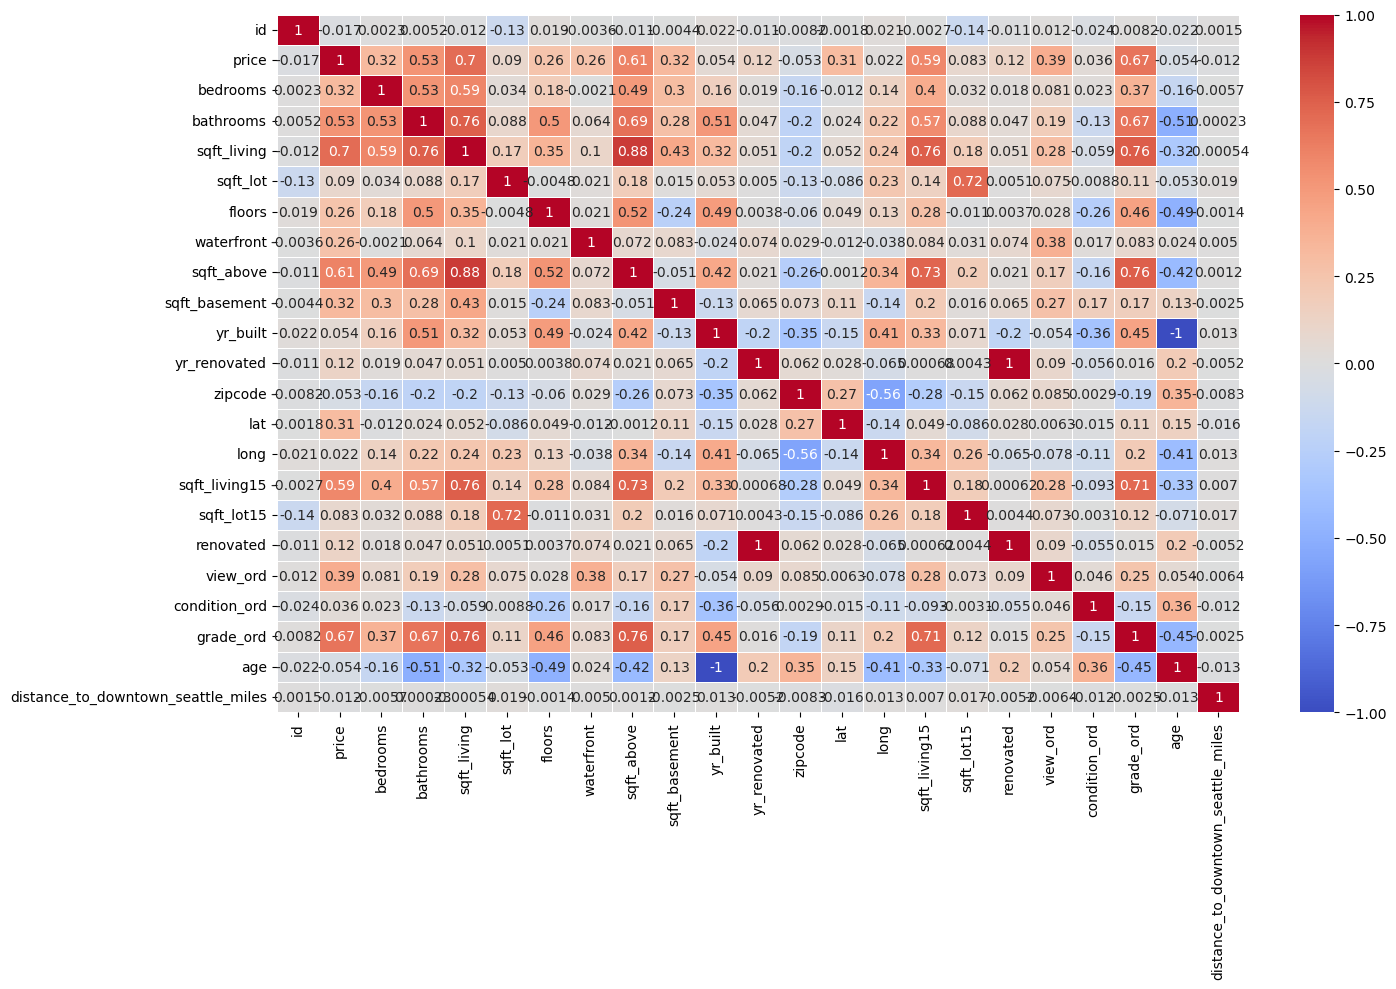

In [33]:
# plotting a heatmap for the correlation of each column to each other

fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(transformed_df.corr(), center = 0, cmap = "coolwarm", annot=True, linewidths=.5, ax=ax)
plt.tight_layout()

In [35]:
desired_columns = ['bedrooms', 'bathrooms', 'sqft_living',
'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'view_ord',
'distance_to_downtown_seattle_miles']

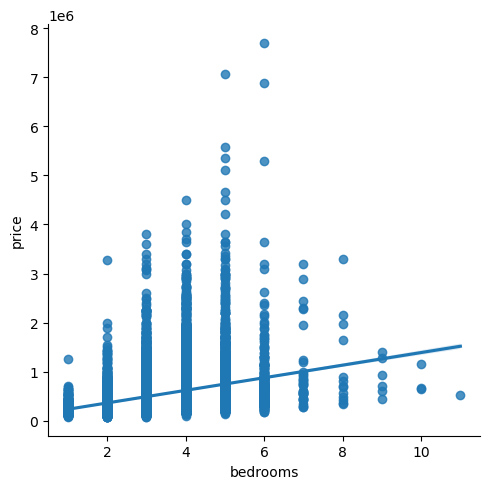

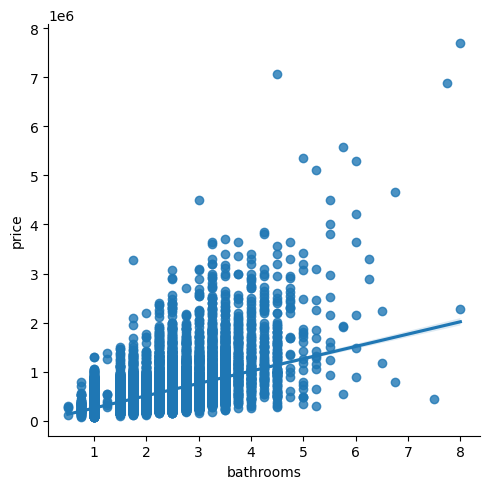

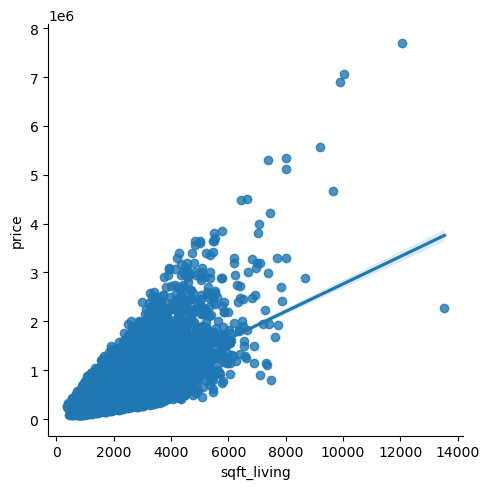

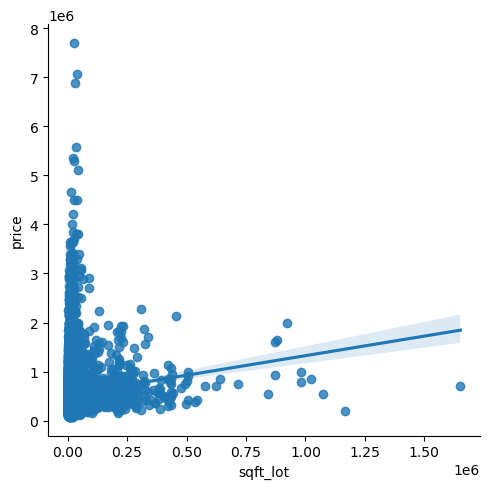

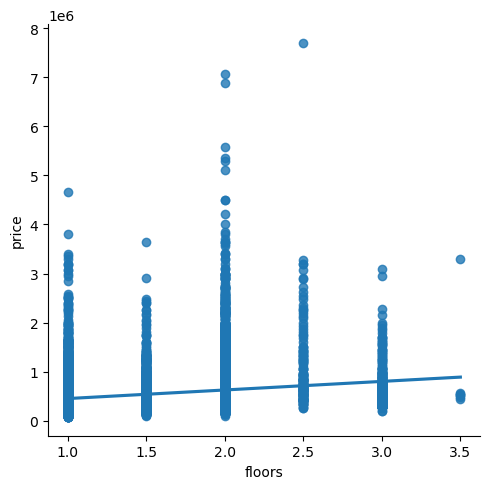

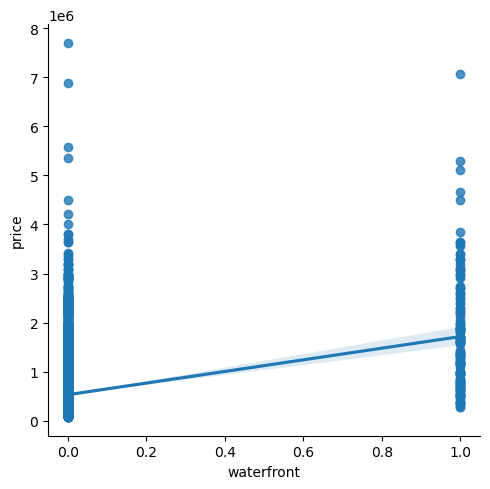

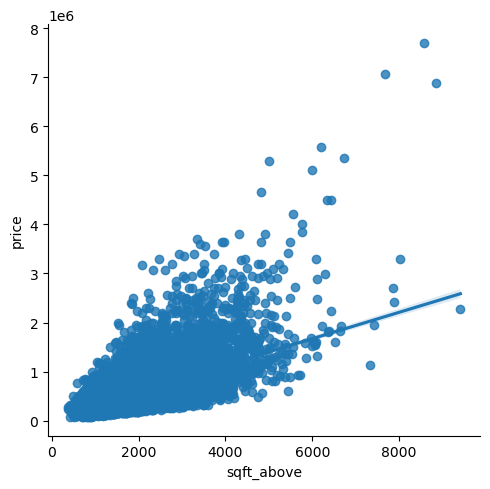

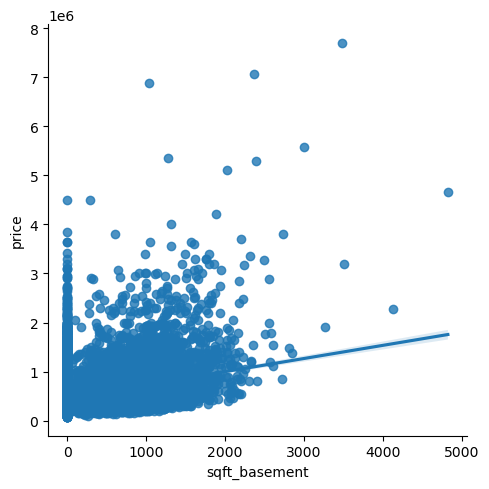

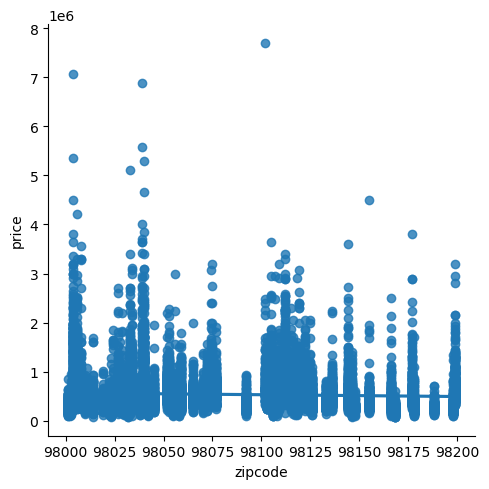

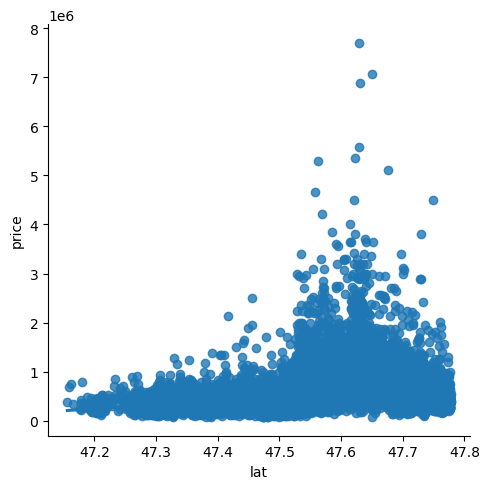

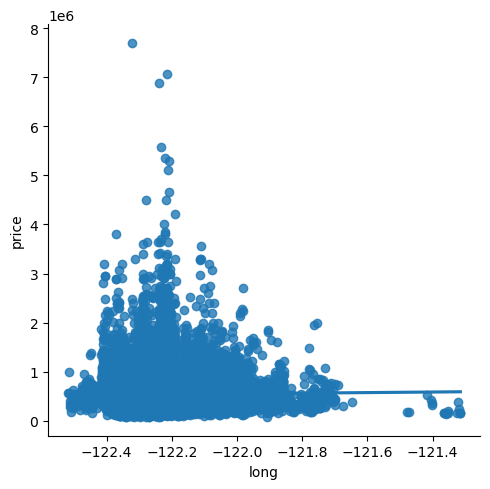

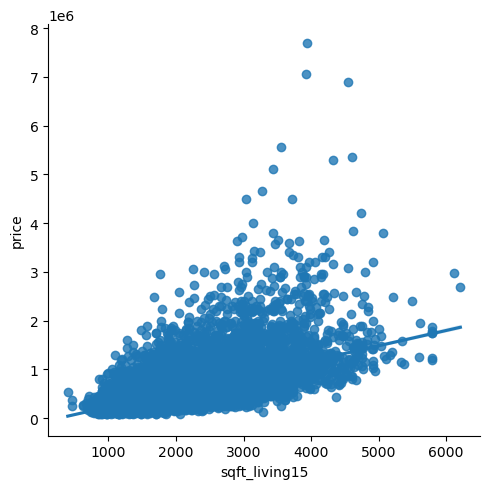

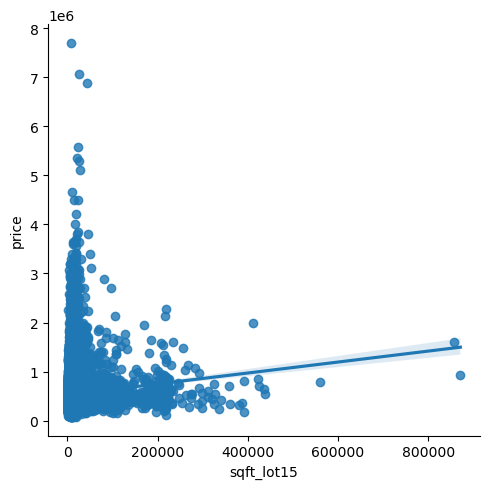

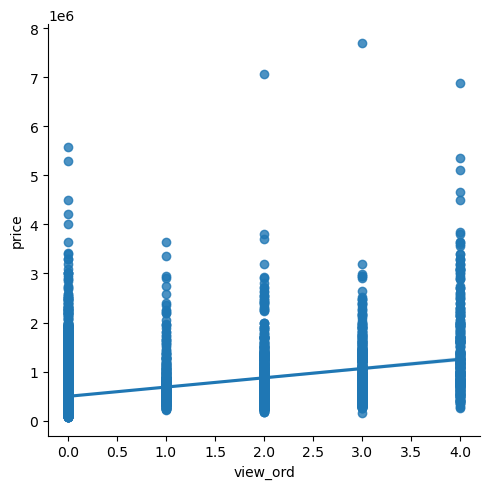

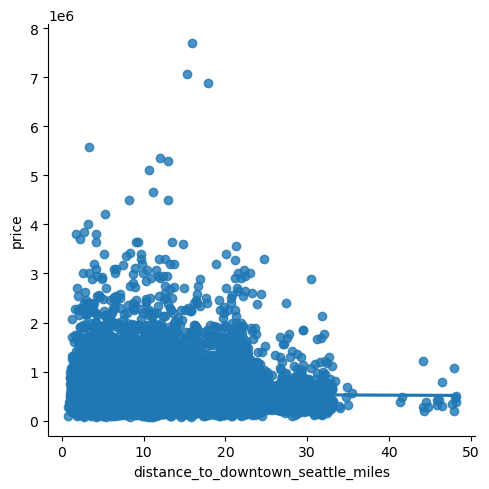

In [36]:
for col in desired_columns:
    sns.lmplot(data=transformed_df, x = col,  y="price", fit_reg =True)

In [32]:
#transformed_df.to_excel("king_county_home_sales.xlsx") #only run this line if this is your first time running this notebook

Finaly we are ready to move onto the model fitting portion of our project. Notice that this is just a preliminary EDA with only the data that was provided for us. However, after doing some basic linear regression models with this data we will return to this phase and try to fit additional data. For example, all our of home sales data is from the year 2014 to 2015 specifically from the kings county region. In order to better anlysis the price of a home in this region we should try to find more recent data, such as data from 2020-2022. Also, in order to better estimate the price of a home, we would like to calculate data such as distance to the nearest park, walking score, distance to public transit, neighborhood score, and demographic data.